### Optimizers and Learning Rate Schedules in the MNIST_FASHION Database

In this tutorial, you will study the effect of a Learning Rate Policy on the SGD and other optimizers
for the MNIST-FASHION Database.

***Do not change the number of iterations neither the initial value of learning rate:***


In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#Do not change the number of epochs neither the initial value of learning rate:
num_epochs = 10
ini_LR = .01 #Initial value of Learning Rate

In [3]:
# Run code with tensorflow version 1.x
%tensorflow_version 1.x

import keras
keras.backend.set_image_data_format('channels_last')
from keras.callbacks import *

class CyclicLR(Callback):
    """SOURCE: https://github.com/bckenstler/CLR"""
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

Using TensorFlow backend.


In [0]:
from keras.optimizers import *
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, Conv2D, MaxPooling2D


In [0]:
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=np.random.randint(300))

x_train=np.expand_dims(x_train,3)
y_train = np_utils.to_categorical(y_train)
x_val=np.expand_dims(x_val,3)
y_val_ori=y_val
y_val = np_utils.to_categorical(y_val)



x_test=np.expand_dims(x_test,3)
#y_test = np_utils.to_categorical(y_test)

x_train=x_train/255
x_test=x_test/255
x_val=x_val/255
input_shape=(28,28,1)




In [0]:
def getModel(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(8, (3,3), strides=(1,1), activation='relu',kernel_initializer='glorot_normal')(X_input)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(16, (3,3), strides=(1,1), activation='relu',kernel_initializer='glorot_normal')(X)
    X = MaxPooling2D((2,2))(X)    
    X = Conv2D(32, (2,2), strides=(1,1), activation='relu',kernel_initializer='glorot_normal')(X)
    X = MaxPooling2D((2,2))(X)
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(.3)(X)
    X = Dense(32, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=[X_input], outputs=[X])
    return model

In [7]:
model=getModel(input_shape)
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          2080      
____

In [8]:
#Try other optimizers:
#SGD, Adam, Nadam, RMSprop
model=getModel(input_shape)
model.compile(optimizer=SGD(ini_LR), loss='categorical_crossentropy', metrics=['accuracy'])
training=model.fit(x_train, y_train, batch_size=64, epochs=num_epochs, validation_data=(x_val, y_val), verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/10





48000/48000 [==============================] - 7s 145us/step - loss: 2.0889 - acc: 0.2499 - val_loss: 1.2036 - val_acc: 0.6351
Epoch 2/10
48000/48000 [==============================] - 4s 80us/step - loss: 1.0442 - acc: 0.6084 - val_loss: 0.7554 - val_acc: 0.7193
Epoch 3/10
48000/48000 [==============================] - 4s 80us/step - loss: 0.8217 - acc: 0.6957 - val_loss: 0.6639 - val_acc: 0.7511
Epoch 4/10
48000/48000 [==============================] - 4s 79us/step - loss: 0.7429 - acc: 0.7234 - val_loss: 0.6313 - val_acc: 0.7602
Epoch 5/10
48000/48000 [==============================] - 4s 79us/step - loss: 0.6944 - acc: 0.7406 - val_loss: 0.5978 - val_acc: 0.7762
Epoch 6/10
48000/48000 [==============================] - 4s 78us/step - loss: 0.6591 - acc: 0.7542 - val_loss: 0.5690 - val_acc: 0.7829
Epoch 7/10
48000/48000 

## **Question 1: Do you obtain the best accuracy in validation set using Classical SGD in this example?** 
Answer here

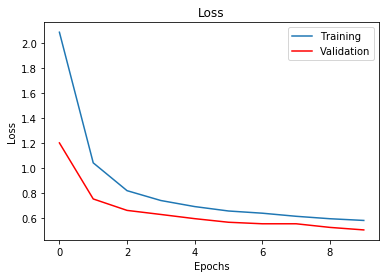

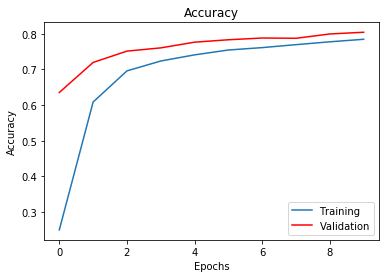

In [9]:
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

###  Training a model using a "Learning Rate Policy"

In [10]:
# Dictionary for easy access to object classes
objects = {0: 'T-shirt',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

#Example of Analysis of Performance for a Model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred=np.argmax(model.predict(x_test),axis=1)
cnf_matrix = confusion_matrix(y_pred, y_test)
np.set_printoptions(precision=3)
print(cnf_matrix)

[[789   1  11  27   0   0 245   0   2   0]
 [  3 947   3  13   2   0   2   0   1   0]
 [ 45   4 660  23  96   0 231   0  23   0]
 [109  39  15 873  54   2  74   0   8   1]
 [ 12   6 234  44 765   0 237   0  10   0]
 [  2   0   0   0   0 927   0  37   9  14]
 [ 29   2  67  16  77   0 193   0   5   0]
 [  0   0   0   0   0  46   0 924   4  59]
 [ 11   1  10   4   6   5  18   0 937   1]
 [  0   0   0   0   0  20   0  39   1 925]]


In [11]:
y_pred_val=np.argmax(model.predict(x_val),axis=1)
print(accuracy_score(y_pred_val, y_val_ori))

y_pred=np.argmax(model.predict(x_test),axis=1)
print(accuracy_score(y_pred, y_test))

0.804
0.794


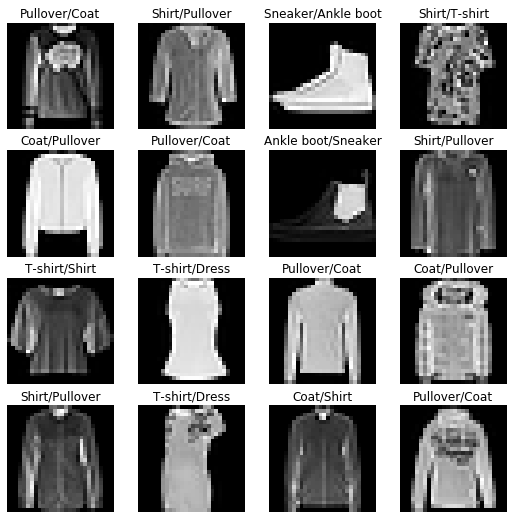

In [12]:
#VISUALIZING SOME ERRORS
val=np.nonzero(abs(y_pred-y_test))[0]
f, axes = plt.subplots(4, 4, figsize=(9,9))
for row in axes:
    for axe in row:
        index = np.random.randint(len(val))
        img = x_test[val[index]]
        obj = y_test[val[index]] #TRUE CLASS
        obj2 = y_pred[val[index]] #PREDICTED CLASS
        axe.imshow(img[:,:,0]*255, cmap='gray')
        axe.set_title(objects[obj]+'/'+objects[obj2])
        axe.set_axis_off()
plt.show()

In [0]:
#Optimizers:
#SGD, Adam, Nadam, RMSprop
clr_triangular = CyclicLR(mode='triangular',base_lr=ini_LR, max_lr=2*ini_LR,step_size=200)
model2=getModel(input_shape)
model2.compile(optimizer=Nadam(ini_LR), loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#Learning Rate Policy is included in the Callbacks

training2=model2.fit(x_train, y_train, batch_size=64, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[clr_triangular], verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 132us/step - loss: 0.6919 - acc: 0.7433 - val_loss: 0.4982 - val_acc: 0.8178
Epoch 2/10
48000/48000 [==============================] - 6s 122us/step - loss: 0.5525 - acc: 0.7983 - val_loss: 0.5087 - val_acc: 0.8143
Epoch 3/10
48000/48000 [==============================] - 6s 121us/step - loss: 0.5279 - acc: 0.8110 - val_loss: 0.5240 - val_acc: 0.8110
Epoch 4/10
48000/48000 [==============================] - 6s 125us/step - loss: 0.5302 - acc: 0.8123 - val_loss: 0.4779 - val_acc: 0.8323
Epoch 5/10
48000/48000 [==============================] - 6s 123us/step - loss: 0.5282 - acc: 0.8107 - val_loss: 0.4710 - val_acc: 0.8267
Epoch 6/10
48000/48000 [==============================] - 6s 121us/step - loss: 0.5231 - acc: 0.8120 - val_loss: 0.5178 - val_acc: 0.8075
Epoch 7/10
48000/48000 [==============================] - 6s 121us/step - loss: 0.5229 - acc: 0.8119 - val_loss: 0.4615 - 

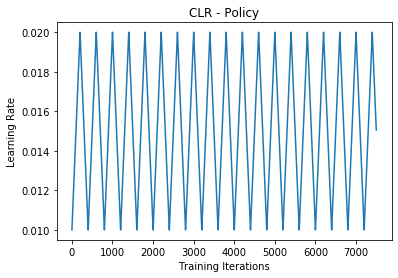

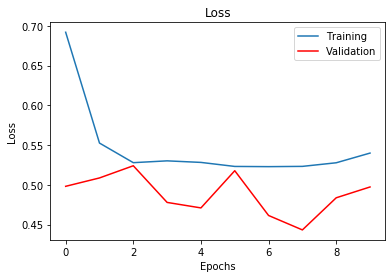

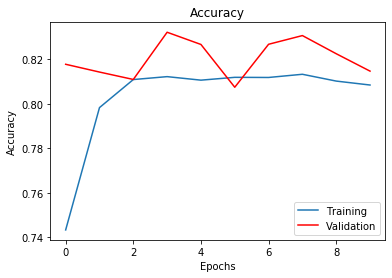

In [15]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])
plt.show()

loss = training2.history['loss']
val_loss = training2.history['val_loss']
acc = training2.history['acc']
val_acc = training2.history['val_acc']

tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

## **Question 2: Is there any improvement using a Cyclic Learning Rate?**
 Plot in a single graph obtained results with several optimizers

In [0]:
## Answer here (with plot or table)

## **Question 3: Can you improve the performance of your networks by changing the optimizer from: SGD, Adam, Nadam, RMSprop?**


In [0]:
## Answer here (with plot or table)

## **Question 4: What if you use 'triangular2' instead of 'triangular' Learning Rate Policy?** 


In [0]:
## Answer here (with plot or table)

## **Question 5: What are the top-3 methods according to accuracy on Training dataset?**


In [0]:
## Answer here (with plot or table)

## **Question 6: What are the top-3 methods according to accuracy on Validation dataset?**


In [0]:
## Answer here (with plot or table)

## **Question 7: What are the top-3 methods according to accuracy on Testing dataset?**


In [0]:
## Answer here (with plot or table)